In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
img_height, img_width = (224,224)  
batch_size = 10
num_epochs = 5
learning_rate = 0.001

In [4]:
train_path = r'./dataset/GuavaDiseaseDataset/train/'
test_path = r'./dataset/GuavaDiseaseDataset/test/'
val_path = r'./dataset/GuavaDiseaseDataset/val/'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),   # resize image
    transforms.ToTensor(),  # convert image to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5, 0.5, 0.5))  # normalize image with mean 0 and std 1
])

# wraps the dataset to enable batching and shuffling for efficient training
trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform)   
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)   

testset = torchvision.datasets.ImageFolder(root=test_path,transform=transform)
testloader = DataLoader(testset,batch_size=batch_size,shuffle=False)

valset = torchvision.datasets.ImageFolder(root=val_path, transform=transform)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)

In [ ]:
## Custom Convolution Class

class GuavaDiseaseCNN(nn.Module):
    def __init__(self):
        super(GuavaDiseaseCNN,self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3,32, kernel_size=3), # Conv. layer with channel 3, fileters 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)            
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # flatten
            nn.Linear(64 * 54*54, 128), # Why 54? => [(224-3+1=222)/2(maxpool)] => [(111-3+1)/2] = 54.5
            nn.ReLU(),
            nn.Dropout(0.35),
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.35),
            
            nn.Linear(128, 3)
        )
        
    def forward(self, x):
        x = self.conv_layer(x)       
                
        x = self.fc_layers(x)
        
        return x


model = GuavaDiseaseCNN().to(device)
loss_fn = nn.CrossEntropyLoss()  
opt = Adam(model.parameters(), lr = learning_rate)


In [ ]:

for epoch in range(num_epochs):
    model.train() # Set model to training mode
    
    running_loss, correct_predictions, total_predictions = 0.0, 0, 0
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        opt.zero_grad() # Reset gradients
        
        pred = model(images)  # Forward pass
        loss = loss_fn(pred.squeeze(), labels)  # Compute loss
        loss.backward()  # Backward pass
        opt.step()  # Update weights
        
        # Track performance metrics
        running_loss += loss.item()
        _, predicted = torch.max(pred,1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        
    train_loss = running_loss / len(trainloader)
    train_accuracy = correct_predictions / total_predictions * 100
    
    # Set model to evaluation mode
    model.eval()
    val_loss, val_correct_predictions, val_total_predictions = 0.0, 0, 0
    
    with torch.no_grad():  # No gradient computation
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            val_loss += loss_fn(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_predictions += labels.size(0)

    val_loss /= len(valloader)
    val_accuracy = val_correct_predictions / val_total_predictions * 100

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    

Epoch [1/5], Train Loss: 0.7855, Train Accuracy: 64.98%, Val Loss: 0.5344, Val Accuracy: 78.15%
Epoch [2/5], Train Loss: 0.5418, Train Accuracy: 79.75%, Val Loss: 0.4889, Val Accuracy: 83.97%
Epoch [3/5], Train Loss: 0.3484, Train Accuracy: 86.97%, Val Loss: 0.2272, Val Accuracy: 90.73%
Epoch [4/5], Train Loss: 0.2335, Train Accuracy: 92.10%, Val Loss: 0.3014, Val Accuracy: 90.33%
Epoch [5/5], Train Loss: 0.1455, Train Accuracy: 95.01%, Val Loss: 0.1782, Val Accuracy: 94.04%


In [10]:
import matplotlib.pyplot as plt

In [ ]:
def predict_image(image_path):
    model.eval()
        
    img = Image.open(image_path).convert('RGB') # Load and convert image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original Image")
    plt.show()
    img_transform = transform(img).unsqueeze(0)  # Apply transformations and add batch dimension
    
    with torch.no_grad():
        pred = model(img_transform.to(device))  # Forward pass
        
    _, pred_class_indx = torch.max(pred,1)  # Get class index with max score
    class_labels = list(trainloader.dataset.class_to_idx.keys())  # Map index to class
    pred_class_label = class_labels[pred_class_indx.item()]
    
    pred_score = torch.softmax(pred, dim=1)[0][pred_class_indx].item()  # Get confidence score
    
    return pred_class_label, pred_score

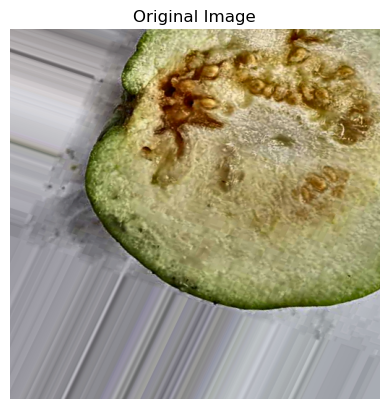

The Predicted class is: fruit_fly with Score: 0.9959


In [16]:
image_file = './dataset/GuavaDiseaseDataset/test/fruit_fly/20230622_155831_unsharp_clahe_augmented_0.png'

predicted_label, predicted_score = predict_image(image_file)
print(f"The Predicted class is: {predicted_label} with Score: {predicted_score:.4f}")